In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color, morphology, measure
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.exposure import histogram
from skimage.morphology import remove_small_objects, opening

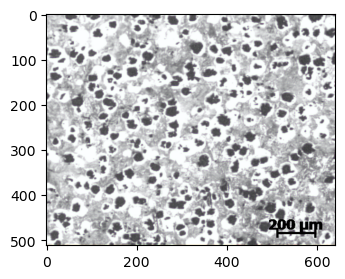

In [96]:
nodule = plt.imread('path to image') 
plt.figure(figsize = (5, 3))
plt.imshow(nodule)

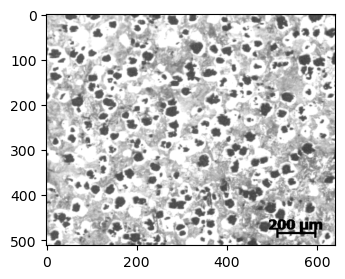

In [98]:
nodule = nodule[:, :, 0:3]   #slicing
nodule = rgb2gray(nodule)
plt.figure(figsize = (5, 3))
plt.imshow(nodule, cmap = 'grey')

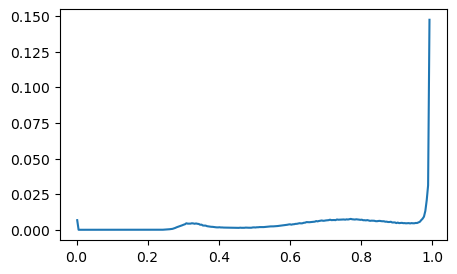

In [100]:
hist, bins = histogram(nodule, nbins = 256)    # hist = frequency of pixel intensities & bins = bin edges
plt.figure(figsize = (5, 3))
plt.plot(bins, hist/np.sum(hist))

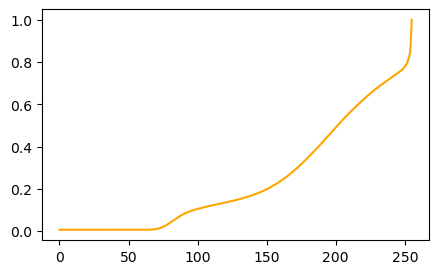

In [102]:
cdf = np.cumsum(hist)
plt.figure(figsize = (5, 3))
plt.plot(cdf/np.sum(hist), color = 'orange')

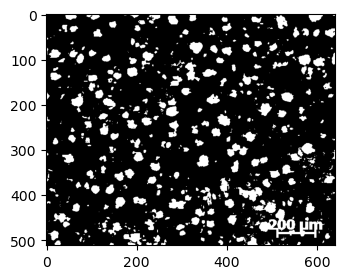

In [104]:
manualThreshold = 0.52
binary = nodule <= manualThreshold    # assigns true or false values
plt.figure(figsize = (6, 3))
plt.imshow(binary, cmap = 'grey')

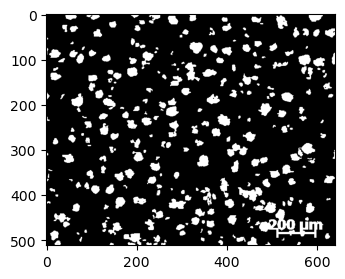

In [106]:
openImg = morphology.opening(binary, footprint = [(np.ones((2, 2)), 1)])   # erosion followed by dilation
openImg = remove_small_objects(openImg, min_size = 20) 
plt.figure(figsize = (6, 3))
plt.imshow(openImg, cmap = 'grey')

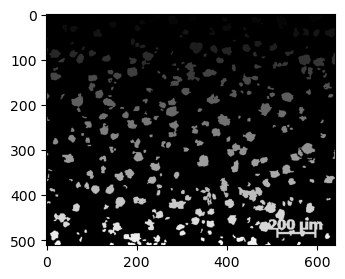

In [108]:
labeledImg = label(openImg) # labeling nodules
labels = morphology.label(openImg)
plt.figure(figsize = (6, 3))
plt.imshow(labeledImg, cmap = 'grey')

In [110]:
props = measure.regionprops(labels)
print("Number of nodules:", len(props))    # numbers of nodules
print("Number of pixels in nodule labeled as 1:", props[0].num_pixels)   # 

Number of nodules: 282
Number of pixels in nodule labeled as 1: 254


In [112]:
c = props[0].coords
print("Shape of 1st nodule:")   # just to show shape of 1st nodule
for i in range(c[:, 0].min(), c[:, 0].max() + 2, 1):
    s = ''
    for j in range(c[:, 1].min() - 3, c[:, 1].max() + 3, 1):
        if openImg[i, j] == True:
            s += '1'
        else:
            s += '0'
    print(s)

Shape of 1st nodule:
000001111111111111111111000000
000011111111111111111111100000
000111111111111111111111110000
000111111111111111111111111000
000111111111111111111111111100
000111111111111111111111111100
000011111111111111111111111100
000011111111111111111111111000
000011111111111111111111111000
000011111111111111111111110000
000000111111111111100000000000
000000000111111110000000000000
000000000000111100000000000000
000000000000000000000000000000


In [114]:
area = []
perimeter = []
shapeIndex = []
for region in regionprops(labeledImg):
    a = region.area
    area.append(a)
    p = region.perimeter
    perimeter.append(f"{p:.2f}")

    if p > 0:
        si = (4 * np.pi * a) / (p ** 2)
        shapeIndex.append(f"{si:.2f}")          # Shape Index = 4*pi*a / p*p     a = area & p = perimeter 
df = pd.DataFrame({
    'Area': area,
    'Perimeter': perimeter,
    'Shape Index': shapeIndex
})
print(df)

      Area Perimeter Shape Index
0    254.0     63.21        0.80
1    252.0     84.87        0.44
2    108.0     42.97        0.74
3    288.0    105.53        0.32
4    211.0     56.14        0.84
..     ...       ...         ...
277   78.0     40.49        0.60
278   56.0     29.90        0.79
279   36.0     21.66        0.96
280   38.0     22.24        0.97
281   43.0     26.49        0.77

[282 rows x 3 columns]


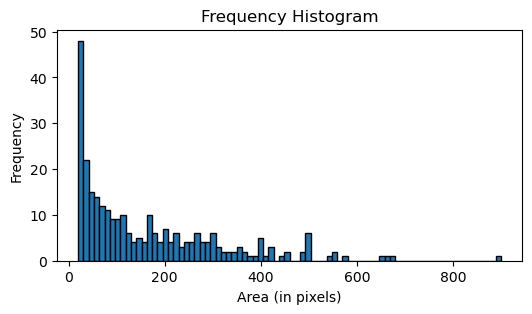

In [116]:
filteredArea = [value for value in area if value <= 1000]  # to remove area due to scale in bottom right as it is only above 3000px
plt.figure(figsize = (6, 3))
plt.hist(filteredArea, bins = 80, edgecolor = 'black')
plt.xlabel('Area (in pixels)')
plt.ylabel('Frequency')
plt.title('Frequency Histogram')
plt.show()

In [118]:
mean = np.mean(area)
std = np.std(area)

print(f"Mean Area (in pixels): {f"{mean:.2f}"}")
print(f"Standard Deviation of Area: {f"{std:.2f}"}")

Mean Area (in pixels): 173.52
Standard Deviation of Area: 231.91


In [120]:
shapeIndex = [float(i) for i in shapeIndex]
avgShape = np.mean(shapeIndex)
print(f"Average Shape Index: {avgShape:.3f}")

Average Shape Index: 0.816


### Shape index shows how close a shape is to being a circle. A higher number means it is more circular. 
### Shape index of 0.816 means the shape is not a perfect circle but fairly round.

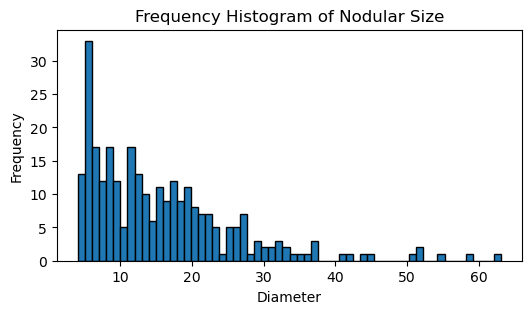

In [123]:
diameter = []
for region in regionprops(labeledImg):
    perimeter = region.perimeter
    if perimeter > 0:
        d = perimeter / ( np.pi)
        diameter.append(d)
dia = [value for value in diameter if value <= 100]       
plt.figure(figsize = (6, 3))
plt.hist(dia, bins = 60, edgecolor='black')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.title('Frequency Histogram of Nodular Size')
plt.show()

In [125]:
totalNoduleArea = sum(area)
areaFraction = totalNoduleArea / (512 * 640)
print(f"Area fraction using Direct Area Method: {areaFraction:.4f}")

Area fraction using Direct Area Method: 0.1493


In [127]:
h = 512  # height of nodule image
w = 640  # width of nodule image
gridSpace = 10

Y, X = np.mgrid[0:h:gridSpace, 0:w:gridSpace]
points = np.vstack([X.ravel(), Y.ravel()]).T      # to store grid points

pointsInNodule = 0
for point in points:
    x, y = point
    if openImg[int(y), int(x)]:
        pointsInNodule += 1

totalGridPoints = points.shape[0]
areaFraction = pointsInNodule / totalGridPoints

print(f"Area fraction using Point Counting: {areaFraction:.4f}")

Area fraction using Point Counting: 0.1553
